In [1]:
!nvidia-smi | grep '/vol/bitbucket/ms922/myenv/bin/python' | awk '{ print $5 }' | xargs -n1 kill -9


Usage:
 kill [options] <pid> [...]

Options:
 <pid> [...]            send signal to every <pid> listed
 -<signal>, -s, --signal <signal>
                        specify the <signal> to be sent
 -q, --queue <value>    integer value to be sent with the signal
 -l, --list=[<signal>]  list all signal names, or convert one to a name
 -L, --table            list all signal names in a nice table

 -h, --help     display this help, and exit
 -V, --version  output version information, and exit

For more details, see kill(1).


In [2]:
!nvidia-smi

Wed Aug  7 16:07:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off | 00000000:1A:00.0 Off |                  Off |
| 31%   53C    P8              30W / 300W |     14MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from dm_ultrasound_util import *

/vol/bitbucket/ms922/glad/dm_ultrasound_util.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
parser = add_shared_args()

parser.add_argument('--lr_img', type=float, default=10, help='learning rate for pixels or f_latents')
parser.add_argument('--lr_w', type=float, default=.01, help='learning rate for updating synthetic latent w')
parser.add_argument('--lr_g', type=float, default=0.0001, help='learning rate for gan weights')

args = parser.parse_args([])

In [5]:
args.num_eval = 5
args.Iteration = 2_000
args.lr_img = 1
args.dataset = "ultrasound"
args.ipc = 50
args.space = "p"
args.eval_it = 500
args.method = "dm"
args.depth = 4
args.res = 64
args.nz = 100
args.epoch_eval_train = 100

args.use_gan = True
args.per_video = False
args.add_variance = False
args.init_beta_dist = False

args.sample_ratio = 0.01

args.gan_type = "dcgan"

args.init = "random"
assert args.init in ["random", "real"]

assert args.gan_type in ["dcgan", "stylegan2"]

if args.use_gan and args.gan_type == "stylegan2":
    args.method += "_stylegan2"

if not args.use_gan:
    args.method += f"_init_{args.init}"

if args.use_gan and args.gan_type == "stylegan2":
    args.lr_w = 0.001

args.use_sample_ratio = bool(args.sample_ratio is not None or args.sample_ratio > 0)

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = False if args.dsa_strategy in ['none', 'None'] else True
print(args.method)

dm


In [6]:
eval_it_pool = np.arange(0, args.Iteration + 1, args.eval_it).tolist()
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader, loader_train_dict, class_map, class_map_inv = get_dataset(
    args.dataset, args.data_path, args.batch_real, args.res, args=args)

model_eval_pool = get_eval_pool(args.eval_mode, args.model, args.model)

accs_all_exps = dict() # record performances of all experiments
for key in model_eval_pool:
    accs_all_exps[key] = []

data_save = []
args.distributed = torch.cuda.device_count() > 1

In [7]:
if args.use_gan:
    dataset_dict_path = f'dataset_dict_{args.dataset}_gan.pkl'
else:
    dataset_dict_path = f'dataset_dict_{args.dataset}.pkl'

print(dataset_dict_path)

if os.path.exists(dataset_dict_path):
    with open(dataset_dict_path, 'rb') as file:
        images_all, labels_all, indices_class = pickle.load(file)
else:
    images_all, labels_all, indices_class = build_dataset(dst_train, class_map, num_classes)
    dataset_dict = images_all, labels_all, indices_class
    with open(dataset_dict_path, 'wb') as pickle_file:
        pickle.dump(dataset_dict, pickle_file)

dataset_dict_ultrasound_gan.pkl


In [8]:
if args.use_sample_ratio:
    n_sample_list = get_sample_syn_label(labels_all, args.sample_ratio, min_syn=15, max_syn=200)
    print(sum(n_sample_list))
    print(n_sample_list)

618
[ 27  28  43 200  48  71  40  18  43  29  15  26  15  15]


In [9]:
G, zdim = None, None

In [10]:
if args.use_gan:
    mean_tensor = torch.Tensor([0.5])
    std_tensor = torch.Tensor([0.5])
else:
    mean_tensor = torch.Tensor(mean)
    std_tensor = torch.Tensor(std)
unnormalize = transforms.Normalize((-mean_tensor / std_tensor).tolist(), (1.0 / std_tensor).tolist())

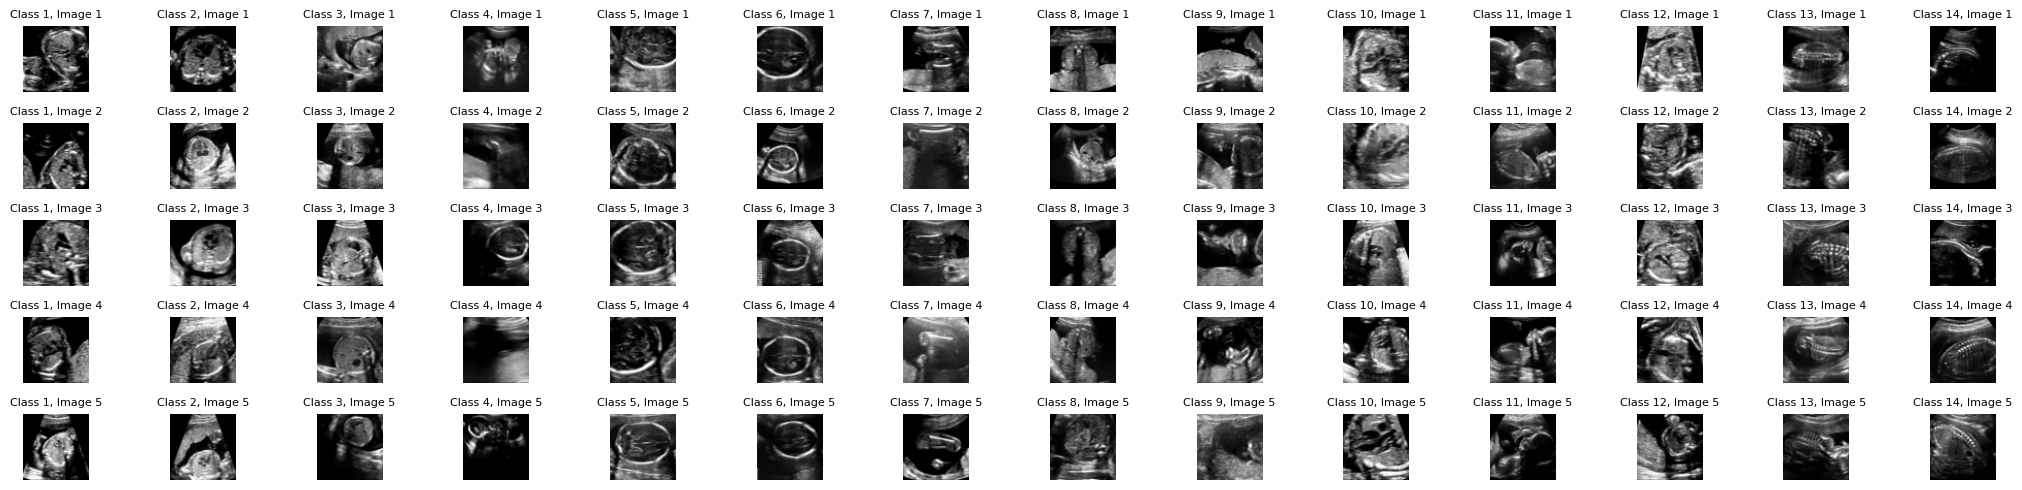

In [11]:
n_img = 5
real_img_tmp_list = [get_images(c, n_img, args, indices_class, images_all) for c in range(num_classes)]
real_img_tmp_tensor = torch.cat(real_img_tmp_list)
display_latent(real_img_tmp_tensor, num_classes, n_img, args, True, channel=channel, im_size=im_size, unnormalize=unnormalize)

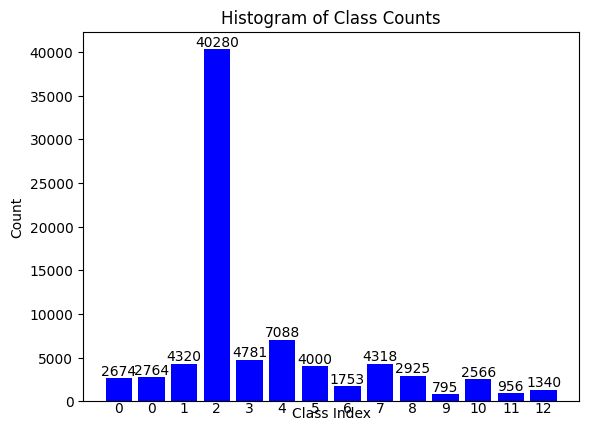

In [12]:
counts = plot_class_distribution(labels_all)

In [13]:
test_class_count = count_classes(testloader)
test_class_count = list(dict(sorted(test_class_count.items())).values())

  0%|          | 0/299 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame({
    "class": [i for i in range(num_classes)],
    "Training Image Count": counts,
    "Subset Image Count": n_sample_list
})
df = df.replace({"class": label_number_to_name_dict})
df = df.sort_values("class")
display(df)

class  Training Image Count  Subset Image Count
4         00_BRAIN-CB                  4781                  48
5         01_BRAIN-TV                  7088                  71
10         02_PROFILE                   795                  15
8             03_LIPS                  4318                  43
2        04_ABDOMINAL                  4320                  43
7          05_KIDNEYS                  1753                  18
6            06_FEMUR                  4000                  40
12   07_SPINE-CORONAL                   956                  15
13  08_SPINE-SAGITTAL                  1340                  15
1              09_4CH                  2764                  28
0              10_3VV                  2674                  27
11            11_RVOT                  2566                  26
9             12_LVOT                  2925                  29
3       13_BACKGROUND                 40280                 200

# Training All

In [17]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

args.epoch_eval_train = 100

res_dict = {}

# model_eval_list = ["ConvNet", "ResNet18", "AlexNet", "VGG11", "ViT"]
model_eval_list = ["ViT"]
eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    # if model_eval == "ConvNet":
    #     continue
    print(f"model: {model_eval}")
    args.lr_net = eval_pool_dict[model_eval]
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) # get a random model
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(it_eval, net, images_all, labels_all, testloader, args, decay="cosine", aug=True)
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    res_dict[model_eval] = metric_test_all

model: ViT


  0%|          | 0/100 [00:00<?, ?it/s]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  1%|          | 1/100 [00:34<57:19, 34.74s/it]


KeyboardInterrupt: 

In [20]:
dir = "../experiment_res/full_dataset"
save_res_dict_excel(res_dict, test_class_count, dir, file_prefix="full_dataset_")

Accuracy avg:0.753482, std:0.001430
Save at: ../experiment_res/full_dataset/full_dataset_ultrasound_050_ViT.xlsx


# Training Random Image subset

In [18]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

args.epoch_eval_train = 500

model_eval_list = ["ConvNet", "ResNet18", "VGG11", "ViT"]
# model_eval_list = ["ViT"]

res_random_dict = {}

eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    args.lr_net = eval_pool_dict[model_eval]
    print(f"model: {model_eval}")
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        if args.per_video:
            random_image_list = torch.cat([get_images_per_video(c, args.ipc, indices_class, images_all) for c in video_id_list])
            random_label_list = torch.tensor([int(c.split("__")[1]) for c in video_id_list for _ in range(args.ipc)])
        else:
            random_image_list = torch.cat([get_images(c, args.ipc, args, indices_class, images_all) for c in range(num_classes)])
            random_label_list = torch.tensor([label for label in range(num_classes) for _ in range(args.ipc)])
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) 
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(
            it_eval, net, random_image_list, random_label_list, testloader, args, decay="cosine", aug=True
        )
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    
    res_random_dict[model_eval] = metric_test_all

model: ConvNet


  0%|          | 0/500 [00:00<?, ?it/s]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 1/500 [00:00<03:22,  2.46it/s]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 2/500 [00:00<02:01,  4.10it/s]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cud

KeyboardInterrupt: 

In [ ]:
dir = "../experiment_res/random"
save_res_dict_excel(res_random_dict, test_class_count, dir, file_prefix="random_")

Accuracy avg:0.110321, std:0.019494


# Random with Ratio

In [155]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

args.epoch_eval_train = 500

model_eval_list = ["ConvNet"]
# model_eval_list = ["ViT"]

res_random_dict = {}

eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    args.lr_net = eval_pool_dict[model_eval]
    print(f"model: {model_eval}")
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        random_image_list = torch.cat([get_images(c, n_sample_list[c], args, indices_class, images_all) for c in range(num_classes)])
        random_label_list = torch.tensor([i for i in range(num_classes) for _ in range(n_sample_list[i])])
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) 
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(
            it_eval, net, random_image_list, random_label_list, testloader, args, decay="cosine", aug=True
        )
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    
    res_random_dict[model_eval] = metric_test_all

model: ConvNet


100%|██████████| 500/500 [00:51<00:00,  9.72it/s]


In [157]:
if args.use_sample_ratio:
    save_name = f'random_sample_{str(args.sample_ratio).replace(".", "__")}_'
else:
    save_name = f"random_sample_{args.ipc}_"

dir = "../experiment_res/random"
save_res_dict_excel(res_random_dict, test_class_count, dir, file_prefix=save_name)

Accuracy avg:0.765541, std:0.004335


# Load Pretrained GAN

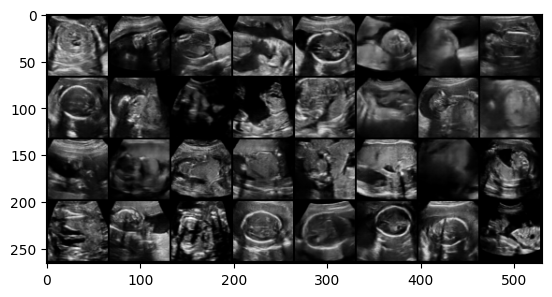

In [15]:
gan_model_path = "./gan/models/net_G_relu_64_video_net_new_epoch_49.pth"
if args.use_gan:
    generator = get_dcgan(args, gan_model_path, ngf=64, channel=channel, display_img=True, unnormalize=unnormalize)
else:
    generator = None

# Training DM

In [34]:
# run = wandb.init(
#     project="GLaD",
#     job_type=args.method.upper(),
#     config=args
# )

In [35]:
# if args.use_sample_ratio:
#     print(f"Sample with ratio of {args.sample_ratio}")
#     latents, f_latents, label_syn = get_latent_sample(n_sample_list, args, num_classes=num_classes, channel=channel, im_size=im_size)
# else:
#     print(f"Sample with number of {args.ipc}")
#     latents, f_latents, label_syn = get_latent_ipc(args, num_classes=num_classes)

# print(latents.shape)

In [16]:
latents = run_dm(
    args, 
    indices_class, 
    images_all, 
    channel, 
    num_classes, 
    im_size=im_size, 
    generator=generator, 
    n_sample_list=n_sample_list, 
    is_save_img=True, 
    is_save_latent=True,
    unnormalize=unnormalize
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jack47744. Use `wandb login --relogin` to force relogin


Sample with ratio of 0.01
Hyper-parameters: 
 {'dataset': 'ultrasound', 'model': 'ConvNet', 'ipc': 50, 'eval_mode': 'M', 'num_eval': 5, 'eval_it': 500, 'save_it': None, 'epoch_eval_train': 100, 'Iteration': 2000, 'mom_img': 0.5, 'batch_real': 256, 'batch_train': 256, 'batch_test': 128, 'pix_init': 'noise', 'dsa': True, 'dsa_strategy': 'color_crop_cutout_flip_scale_rotate', 'data_path': 'data', 'save_path': 'result', 'space': 'p', 'res': 64, 'layer': 12, 'avg_w': False, 'eval_all': False, 'min_it': False, 'no_aug': False, 'force_save': False, 'sg_batch': 10, 'rand_f': False, 'logdir': './logged_files', 'wait_eval': False, 'idc_factor': 1, 'rand_gan_un': False, 'rand_gan_con': False, 'learn_g': False, 'width': 128, 'depth': 4, 'special_gan': None, 'lr_img': 1, 'lr_w': 0.01, 'lr_g': 0.0001, 'method': 'dm', 'nz': 100, 'use_gan': True, 'per_video': False, 'add_variance': False, 'init_beta_dist': False, 'sample_ratio': 0.01, 'gan_type': 'dcgan', 'init': 'random', 'use_sample_ratio': True, 'd

Training Progress:   0%|          | 0/2001 [00:00<?, ?it/s]

/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[2024-08-07 16:08:16] iter = 0000, loss = 40.4356
[2024-08-07 16:08:31] iter = 0050, loss = 8.3573
[2024-08-07 16:08:46] iter = 0100, loss = 6.3040
[2024-08-07 16:09:00] iter = 0150, loss = 5.2377
[2024-08-07 16:09:15] iter = 0200, loss = 4.4701
Save at ./dm_latents/ultrasound/0__01_ori_0200.pt
[2024-08-07 16:09:31] iter = 0250, loss = 4.3340
[2024-08-07 16:09:45] iter = 0300, loss = 4.1321
[2024-08-07 16:10:00] iter = 0350, loss = 3.9481
[2024-08-07 16:10:15] iter = 0400, loss = 3.7020
Save at ./dm_latents/ultrasound/0__01_ori_0400.pt
[2024-08-07 16:10:30] iter = 0450, loss = 3.8205
[2024-08-07 16:10:45] iter = 0500, loss = 3.2078
[2024-08-07 16:11:00] iter = 0550, loss = 3.4064
[2024-08-07 16:11:15] iter = 0600, loss = 3.2992
Save at ./dm_latents/ultrasound/0__01_ori_0600.pt
[2024-08-07 16:11:30] iter = 0650, loss = 3.1718
[2024-08-07 16:11:45] iter = 0700, loss = 3.1228
[2024-08-07 16:12:00] iter = 0750, loss = 2.9904
[2024-08-07 16:12:15] iter = 0800, loss = 2.9357
Save at ./dm_lat

In [18]:
latents_tmp = latents

In [25]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

model_eval_pool = ["ConvNet"]

if args.use_gan:
    optimizer_img = torch.optim.SGD([latents], lr=args.lr_w, momentum=0.5)
else:
    optimizer_img = torch.optim.SGD([latents], lr=args.lr_img, momentum=0.5)
print('Hyper-parameters: \n', args.__dict__)
print('Evaluation model pool: ', model_eval_pool)
print('%s training begins'%get_time())


best_acc = {"{}".format(m): 0 for m in model_eval_pool}

best_std = {m: 0 for m in model_eval_pool}

save_this_it = False
with tqdm(total=args.Iteration + 1, desc="Training Progress") as pbar:
    for it in range(args.Iteration+1):
        if it in eval_it_pool and it > 0:
            if args.use_gan:
                with torch.no_grad():
                    eval_latent = generator(latents)
            else:
                eval_latent = latents

        # ''' Train synthetic data '''
        net = get_network(args.model, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) # get a random model
        net.train()
        for param in list(net.parameters()):
            param.requires_grad = False

        embed = net.module.embed if torch.cuda.device_count() > 1 else net.embed # for GPU parallel

        loss_avg = 0

        if args.use_gan:
            with torch.no_grad():
                if args.gan_type == "dcgan":
                    image_syn_w_grad = generator(latents)
                elif args.gan_type == "stylegan2":
                    image_syn_w_grad = gen_sg2_img(model, latents)
        else:
            image_syn_w_grad = latents

        if args.use_gan:
            image_syn = image_syn_w_grad.detach()
            image_syn.requires_grad_(True)
        else:
            image_syn = image_syn_w_grad

        ''' update synthetic data '''
        if 'BN' not in args.model: # for ConvNet

            print("A")
            loss = torch.tensor(0.0).to(args.device)

            
            for c in range(num_classes):
                img_real = get_images(c, args.batch_real, args, indices_class, images_all).to(args.device)
                if args.use_sample_ratio:
                    img_syn = get_latent_sample_class(c, image_syn, n_sample_list).reshape((n_sample_list[c], channel, im_size[0], im_size[1]))
                else:
                    img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))

                if args.dsa:
                    seed = int(time.time() * 1000) % 100000
                    img_real = DiffAugment(img_real, args.dsa_strategy, seed=seed, param=args.dsa_param)
                    img_syn = DiffAugment(img_syn, args.dsa_strategy, seed=seed, param=args.dsa_param)

                output_real = embed(img_real).detach()
                output_syn = embed(img_syn)

                loss += torch.sum((torch.mean(output_real, dim=0) - torch.mean(output_syn, dim=0))**2)

                if args.add_variance:
                    loss += -0.3*torch.var(output_syn, dim=0).sum()
                    # loss += max(-0.5*torch.var(output_syn, dim=0).sum(), -100) # 14-05-2024

        else: # for ConvNetBN
            print("B")
            images_real_all = []
            images_syn_all = []
            loss = torch.tensor(0.0).to(args.device)
            for c in range(num_classes):
                img_real = get_images(c, args.batch_real, args, indices_class, images_all)
                if args.use_sample_ratio:
                    img_syn = get_latent_sample_class(c, image_syn, n_sample_list).reshape((n_sample_list[c], channel, im_size[0], im_size[1]))
                else:
                    img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))

                if args.dsa:
                    seed = int(time.time() * 1000) % 100000
                    img_real = DiffAugment(img_real, args.dsa_strategy, seed=seed, param=args.dsa_param)
                    img_syn = DiffAugment(img_syn, args.dsa_strategy, seed=seed, param=args.dsa_param)

                images_real_all.append(img_real)
                images_syn_all.append(img_syn)

            images_real_all = torch.cat(images_real_all, dim=0)
            images_syn_all = torch.cat(images_syn_all, dim=0)

            output_real = embed(images_real_all).detach()
            output_syn = embed(images_syn_all)

            loss += torch.sum((torch.mean(output_real.reshape(num_classes, args.batch_real, -1), dim=1) - torch.mean(output_syn.reshape(num_classes, args.ipc, -1), dim=1))**2)

        optimizer_img.zero_grad()
        loss.backward()

        if args.use_gan:
            latents_detached = latents.detach().clone().requires_grad_(True)
            
            if args.gan_type == "dcgan":
                syn_images = generator(latents_detached)
                syn_images.backward((image_syn.grad,))
                latents.grad = latents_detached.grad
            elif args.gan_type == "stylegan2":
                with torch.enable_grad():
                    sg2_backward(latents, image_syn, model, args)
        else:
            latents.grad = image_syn.grad.detach().clone()

        optimizer_img.step()
        loss_avg += loss.item()


        loss_avg /= (num_classes)

        wandb.log({
            "Loss": loss_avg
        }, step=it)

        if it%50 == 0:
            print('%s iter = %04d, loss = %.4f' % (get_time(), it, loss_avg))
            with torch.no_grad():
                
                sample_path = f"./{args.method}_samples/{args.dataset}" if args.use_gan else f"./{args.method}_samples/{args.dataset}_no_gan"

                if not os.path.exists(sample_path):
                    os.makedirs(sample_path)

                save_img_path = f"{sample_path}/fake_{it:04d}.png" if not args.add_variance else f"{sample_path}/var_fake_{it:04d}.png"
                if args.use_gan:
                    if args.gan_type == "dcgan":
                        save_image(denorm(syn_images.cpu(), unnormalize).float(), save_img_path)
                    elif args.gan_type == "stylegan2":
                        with torch.no_grad():
                            latents_detached = latents.detach().clone().requires_grad_(False)
                            syn_images = gen_sg2_img(model, latents_detached)
                        save_image(syn_images.cpu().float(), save_img_path)
                else:
                    save_image(denorm(latents.cpu(), unnormalize).float(), save_img_path)

        # if it == args.Iteration: # only record the final results
        if it % 200 == 0 and it > 0:
            # data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu())])

            if args.use_gan:
                with torch.no_grad():
                    save_latent = generator(latents)
            else:
                save_latent = latents

            latent_path = f"./{args.method}_latents/{args.dataset}" if args.use_gan else f"./{args.method}_latents/{args.dataset}_no_gan"

            if not os.path.exists(latent_path):
                os.makedirs(latent_path)

            if args.use_sample_ratio:
                save_latent_path =  f'{latent_path}/{str(args.sample_ratio).replace(".", "__")}_ori_{it:04d}.pt' if not args.add_variance else f'{latent_path}/var_{str(args.sample_ratio).replace(".", "__")}_ori_{it:04d}.pt'
            else:
                save_latent_path =  f'{latent_path}/{args.ipc}_ori_{it:04d}.pt' if not args.add_variance else f'{latent_path}/var_{args.ipc}_ori_{it:04d}.pt'
            torch.save(save_latent, save_latent_path)
            print(f"Save at {save_latent_path}")

torch.cuda.empty_cache()
gc.collect()

Hyper-parameters: 
 {'dataset': 'ultrasound', 'model': 'ConvNet', 'ipc': 50, 'eval_mode': 'M', 'num_eval': 5, 'eval_it': 500, 'save_it': None, 'epoch_eval_train': 100, 'Iteration': 2000, 'mom_img': 0.5, 'batch_real': 256, 'batch_train': 256, 'batch_test': 128, 'pix_init': 'noise', 'dsa': True, 'dsa_strategy': 'color_crop_cutout_flip_scale_rotate', 'data_path': 'data', 'save_path': 'result', 'space': 'p', 'res': 64, 'layer': 12, 'avg_w': False, 'eval_all': False, 'min_it': False, 'no_aug': False, 'force_save': False, 'sg_batch': 10, 'rand_f': False, 'logdir': './logged_files', 'wait_eval': False, 'idc_factor': 1, 'rand_gan_un': False, 'rand_gan_con': False, 'learn_g': False, 'width': 128, 'depth': 4, 'special_gan': None, 'lr_img': 1, 'lr_w': 0.01, 'lr_g': 0.0001, 'method': 'dm_init_random', 'nz': 100, 'use_gan': False, 'per_video': False, 'add_variance': False, 'init_beta_dist': False, 'sample_ratio': 0.01, 'gan_type': 'dcgan', 'init': 'random', 'use_sample_ratio': True, 'device': 'cuda

Training Progress:   0%|          | 0/2001 [00:00<?, ?it/s]

A
[2024-08-07 15:34:45] iter = 0000, loss = 39.2221
A
A
A
A
A
A
A
A
A
A
A


KeyboardInterrupt: 

In [21]:
latent_dir = f"./{args.method}_latents/{args.dataset}" if args.use_gan else f"./{args.method}_latents/{args.dataset}_no_gan"
if args.use_sample_ratio:
    save_name = f'{str(args.sample_ratio).replace(".", "__")}_ori_2000.pt'
else:
    save_name = f"{args.ipc}_ori_2000.pt"
latent_path = os.path.join(latent_dir, save_name)
latents_tmp = torch.load(latent_path, map_location=args.device, weights_only=True)
print(latent_path)

./dm_init_random_latents/ultrasound_no_gan/0__01_ori_2000.pt


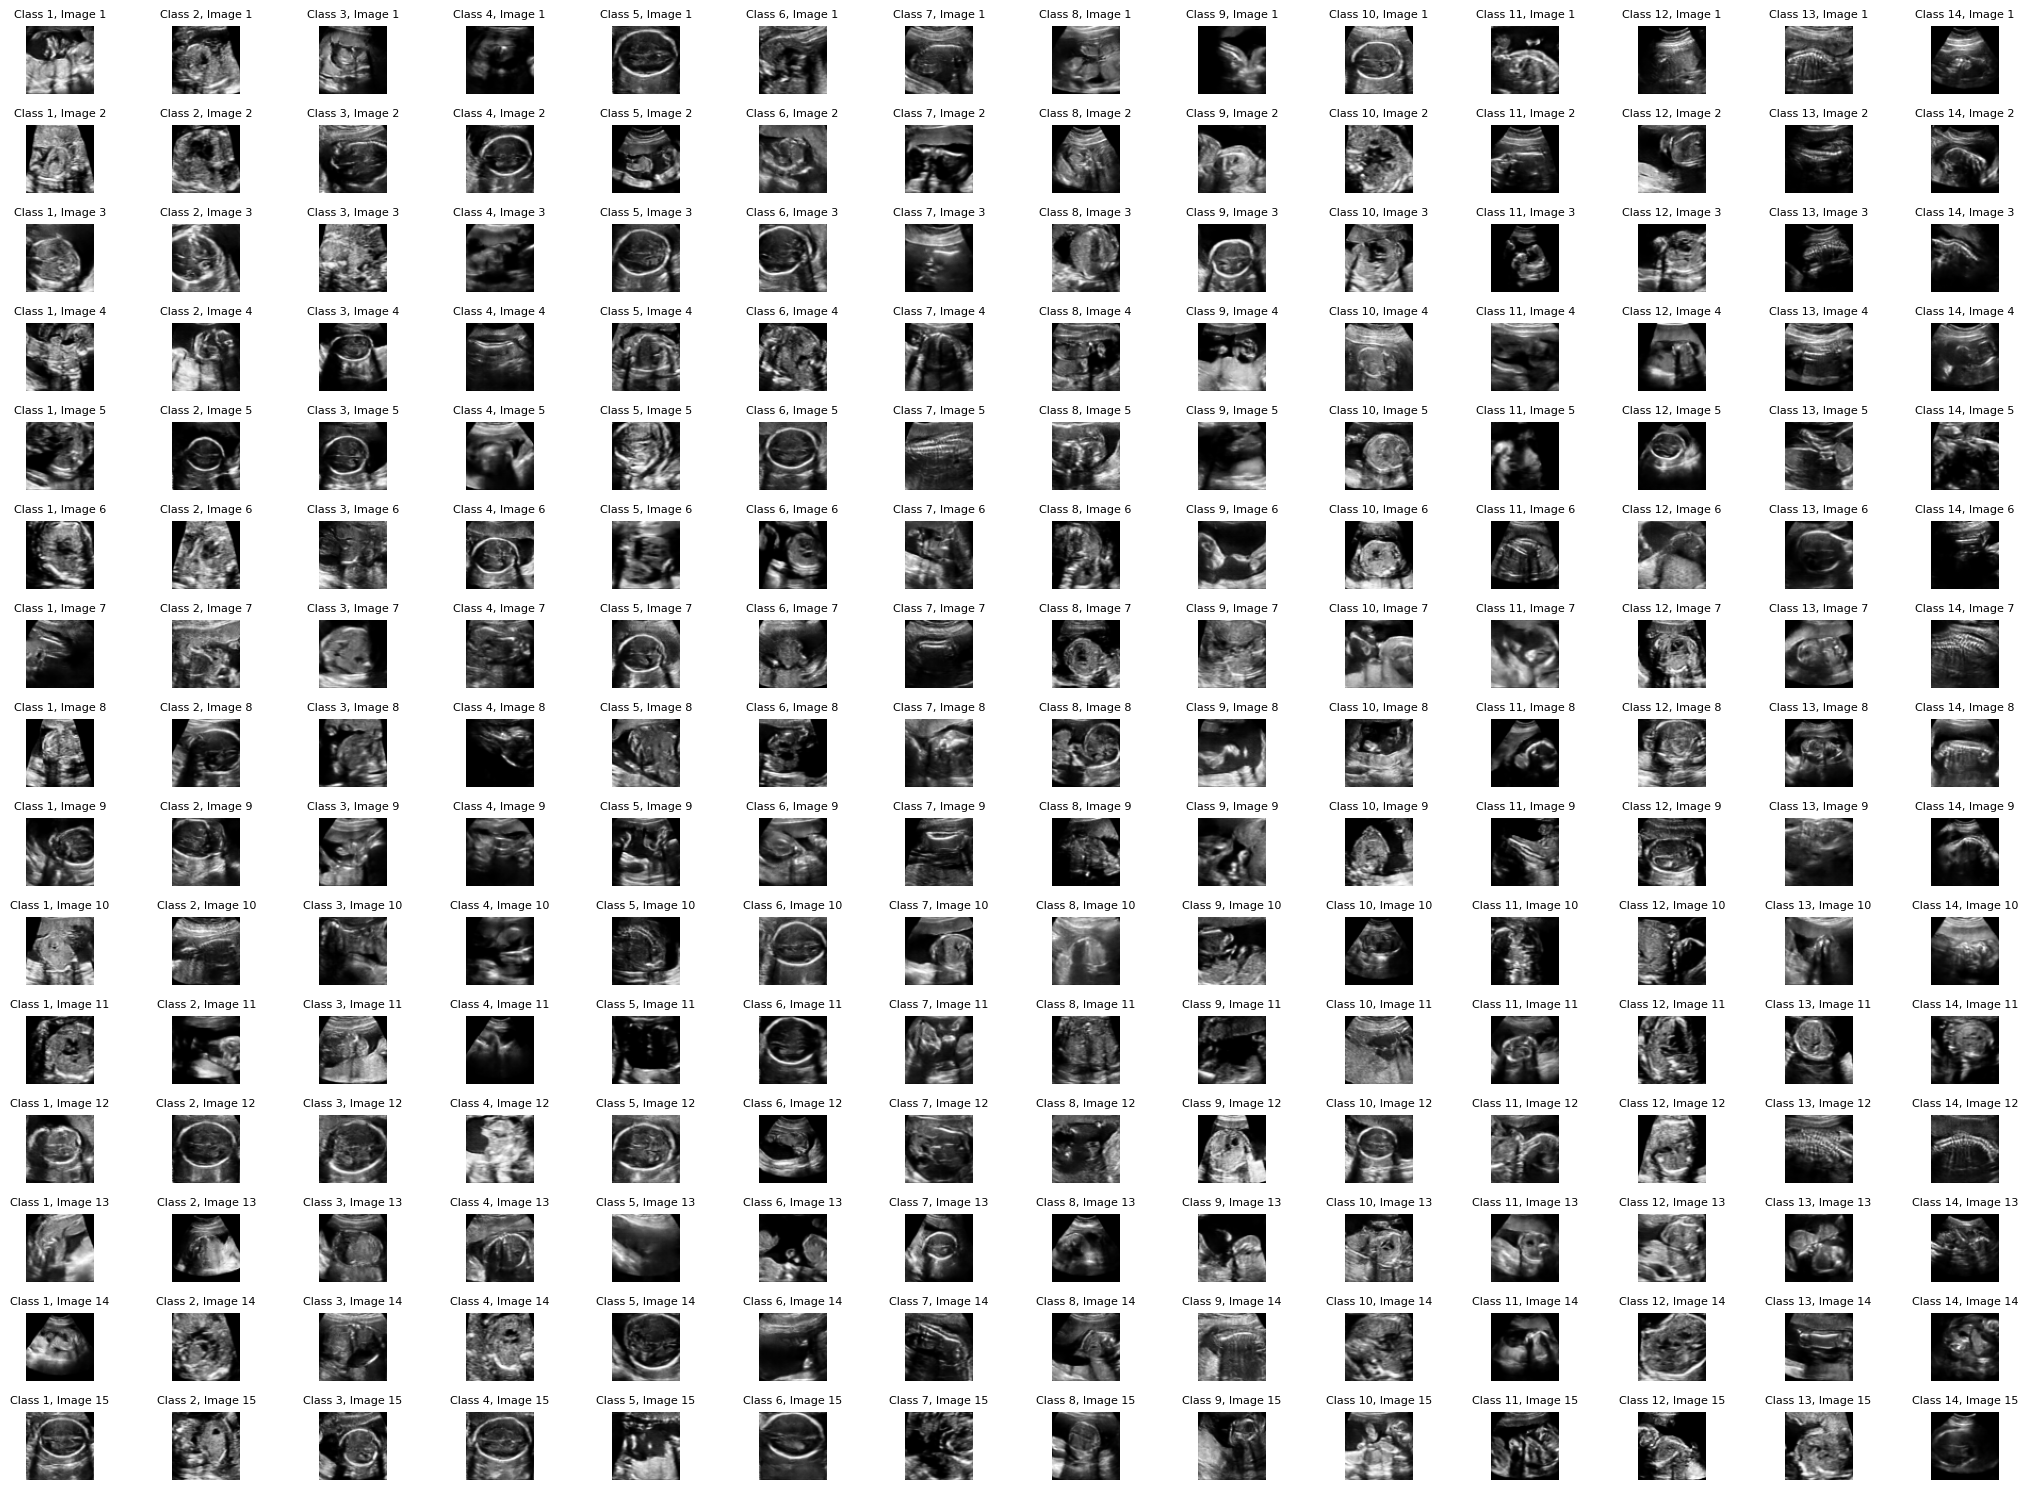

: 

In [19]:
if args.use_sample_ratio:
    sampled_tensors = sample_tensors(latents_tmp, n_sample_list, min(n_sample_list))
    display_latent(sampled_tensors, num_classes, min(n_sample_list), args, True, channel=channel, im_size=im_size, unnormalize=unnormalize)
else:
    display_latent(latents_tmp, num_classes, args.ipc, args, True, channel=channel, im_size=im_size, unnormalize=unnormalize)

In [22]:
# args.epoch_eval_train = 500

# model_eval_pool = ["ConvNet"]
# latents = latents_tmp.reshape(-1, channel, im_size[0], im_size[1])
# if args.use_sample_ratio:
#     label_syn = torch.tensor([i for i in range(num_classes) for _ in range(n_sample_list[i])], dtype=torch.long, requires_grad=False, device=args.device).view(-1)
# else:
#     label_syn = torch.tensor([i*np.ones(args.ipc, dtype=np.int64) for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1)
# res_dict = eval_loop_v2(latents=latents, f_latents=None, label_syn=label_syn, G=None, best_acc=None,
#                 best_std=None, testloader=testloader,
#                 model_eval_pool=model_eval_pool, channel=channel, num_classes=num_classes,
#                 im_size=im_size, it=0, args=args)

-------------------------
Evaluation
model_train = ConvNet, model_eval = ConvNet, iteration = 0


 67%|██████▋   | 334/500 [00:52<00:26,  6.30it/s]

100%|██████████| 500/500 [01:18<00:00,  6.34it/s]


In [23]:
# dir = f"../experiment_res/{args.method}_latent_gen" if args.use_gan else f"../experiment_res/{args.method}_latent_gen_no_gan"
# if args.use_sample_ratio:
#     file_prefix = f'latent_gen_{args.method}_{str(args.sample_ratio).replace(".", "__")}_'  if args.use_gan else f'latent_gen_{args.method}_no_gan_{str(args.sample_ratio).replace(".", "__")}_'
# else:
#     file_prefix = f"latent_gen_{args.method}_"  if args.use_gan else f"latent_gen_{args.method}_no_gan_"
    
# save_res_dict_excel(res_dict, test_class_count, dir, file_prefix=file_prefix)

Accuracy avg:0.689998, std:0.002632


In [23]:
if args.use_sample_ratio:
    tensor_split = split_tensor_to_list(latents_tmp, n_sample_list)
    print([t.shape for t in tensor_split])  # Should print shapes of split tensors

[torch.Size([27, 1, 64, 64]), torch.Size([28, 1, 64, 64]), torch.Size([43, 1, 64, 64]), torch.Size([200, 1, 64, 64]), torch.Size([48, 1, 64, 64]), torch.Size([71, 1, 64, 64]), torch.Size([40, 1, 64, 64]), torch.Size([18, 1, 64, 64]), torch.Size([43, 1, 64, 64]), torch.Size([29, 1, 64, 64]), torch.Size([15, 1, 64, 64]), torch.Size([26, 1, 64, 64]), torch.Size([15, 1, 64, 64]), torch.Size([15, 1, 64, 64])]


In [24]:
embed_list = get_embed_list(args, channel, num_classes, im_size, num_net=10)

if args.use_sample_ratio:
    mse_latent_dict, latent_embed_mean_list, img_latent_mean_all_list = get_most_similar_img(
        tensor_split, args, indices_class, images_all, is_stack=False, embed_list=embed_list, ret_img_latent=True
    )
else:
    mse_latent_dict, latent_embed_mean_list = get_most_similar_img(latents_tmp, args, indices_class, images_all, embed_list=embed_list)

  0%|          | 0/2674 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4320 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/40280 [00:00<?, ?it/s]

KeyboardInterrupt: 

 ----- top k: 1 ----- 


100%|██████████| 618/618 [00:02<00:00, 224.02it/s]


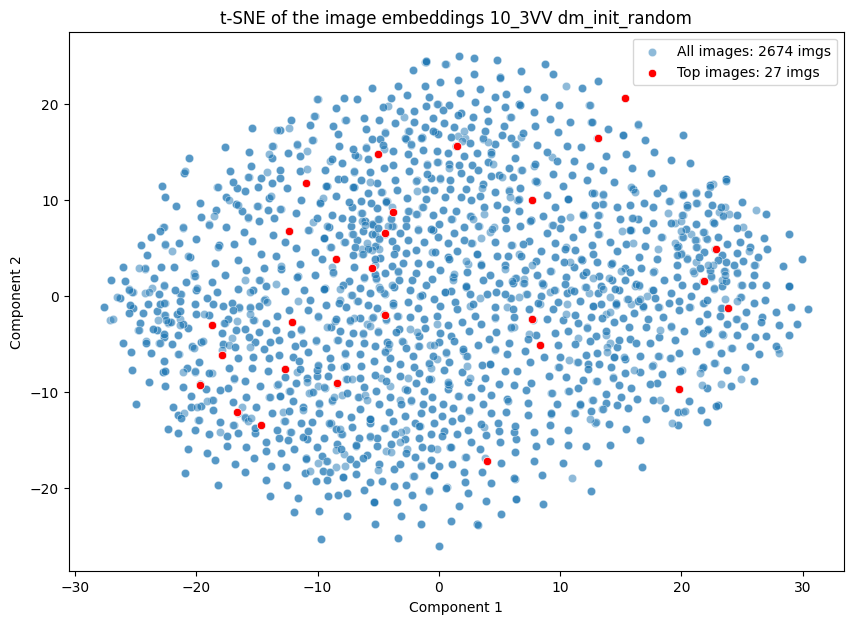

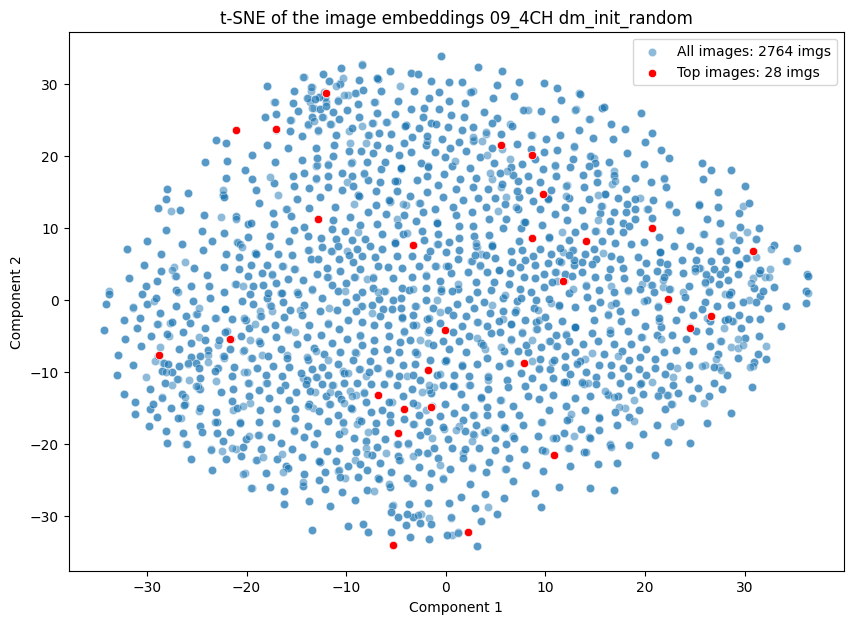

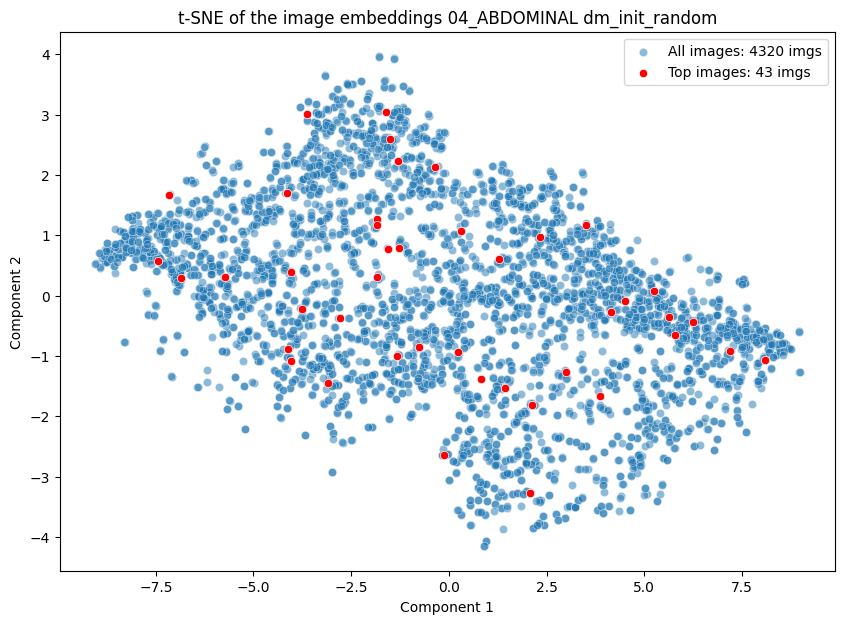

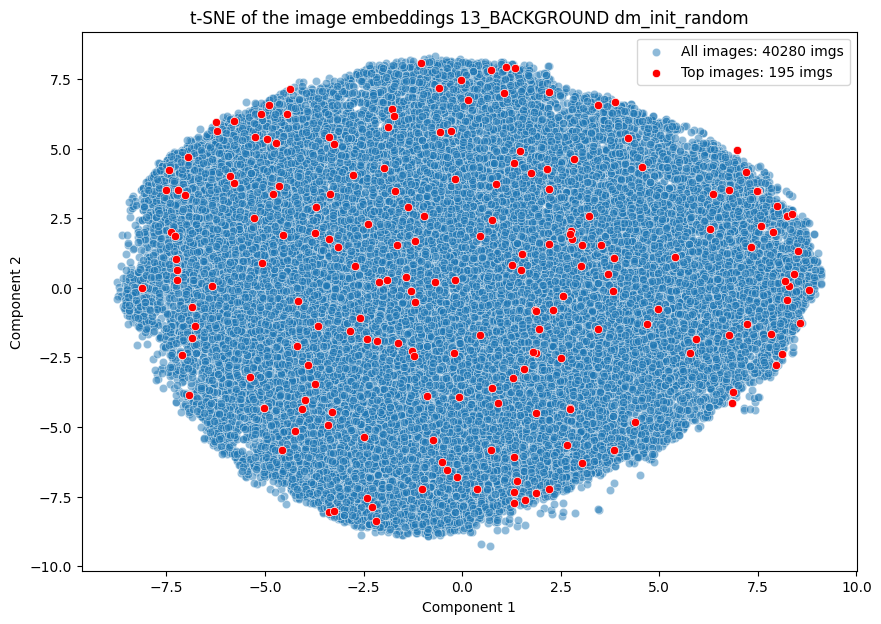

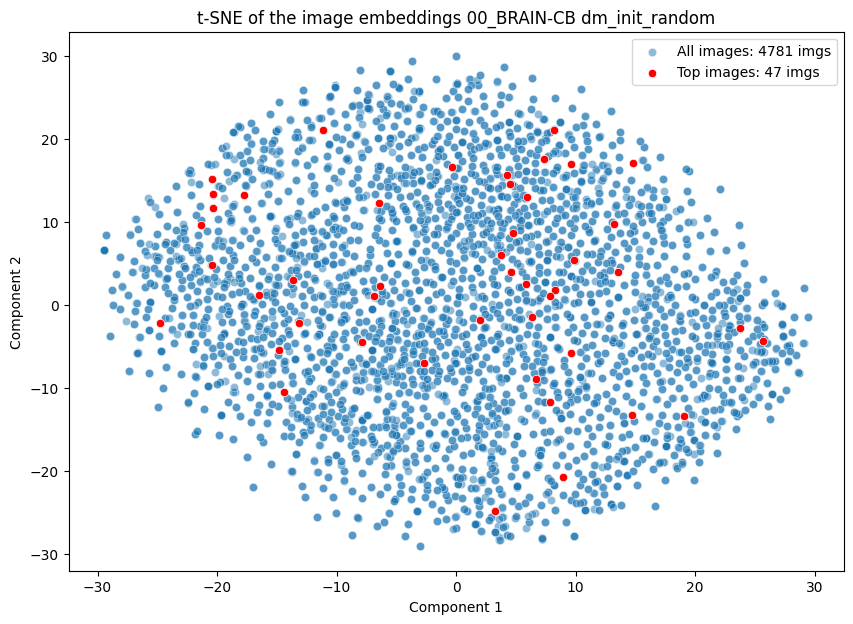

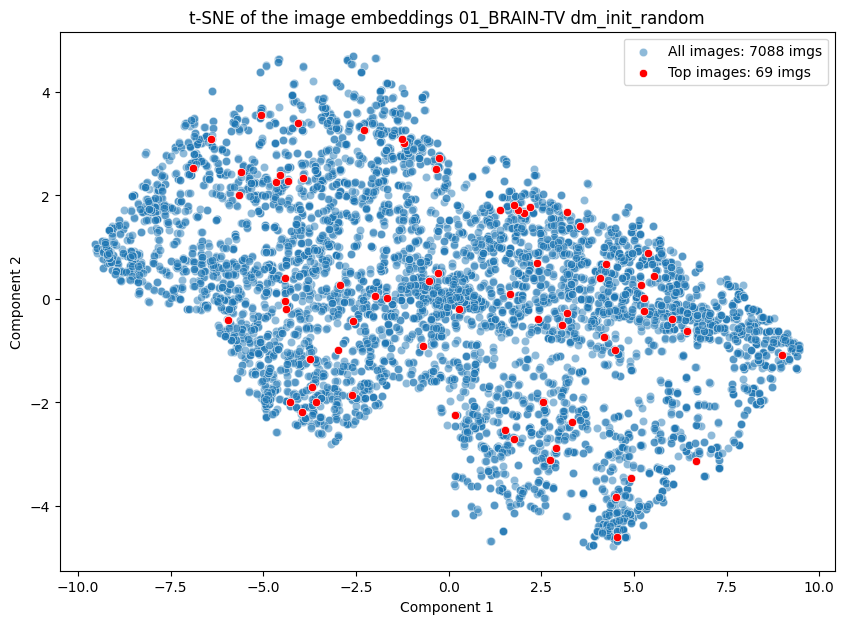

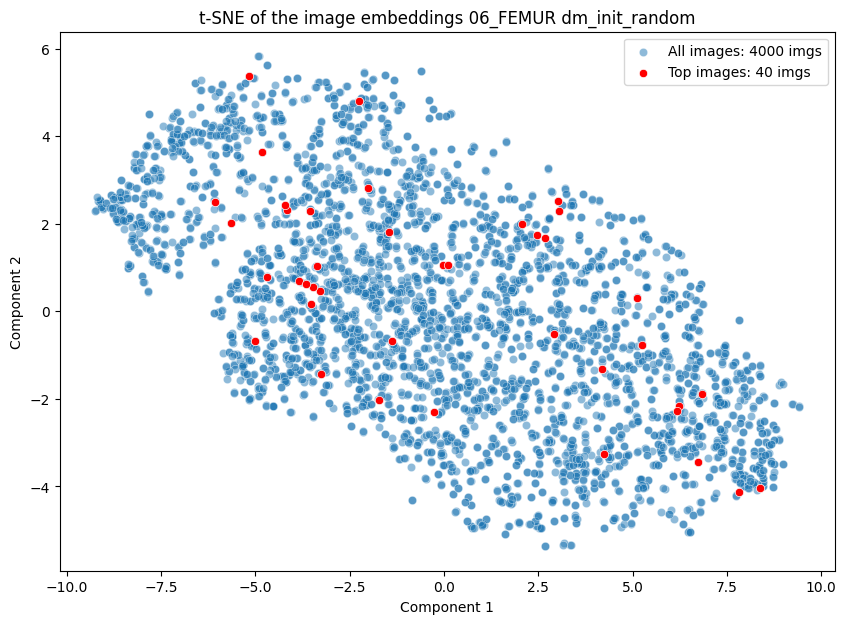

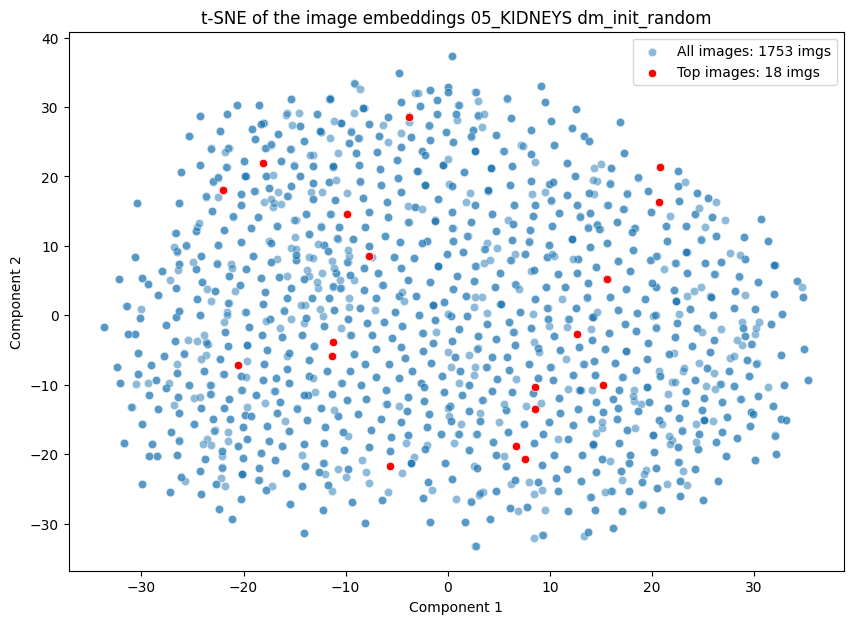

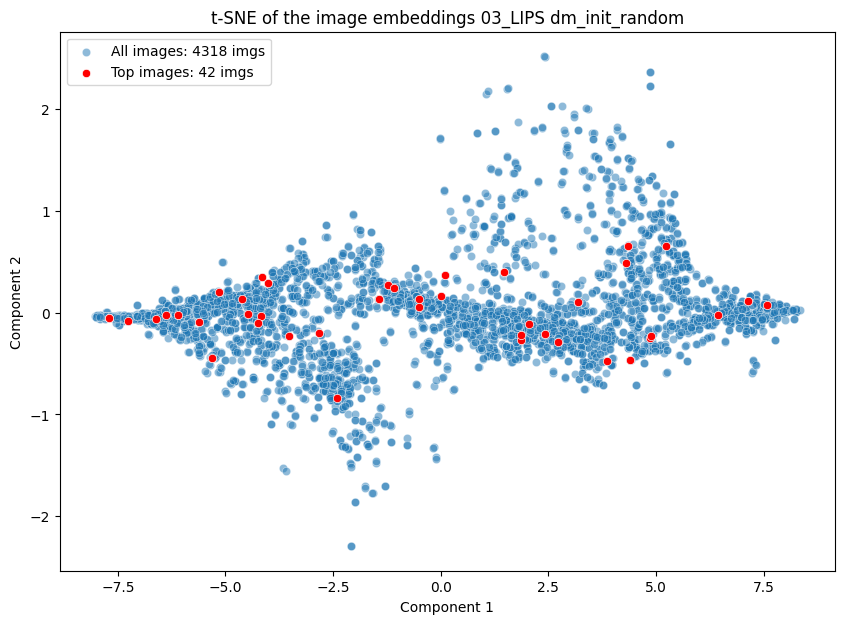

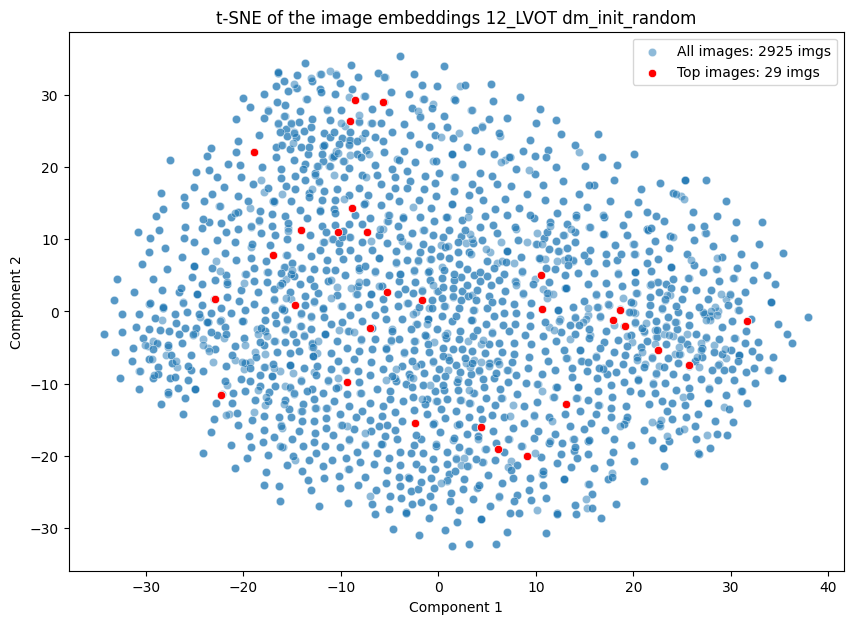

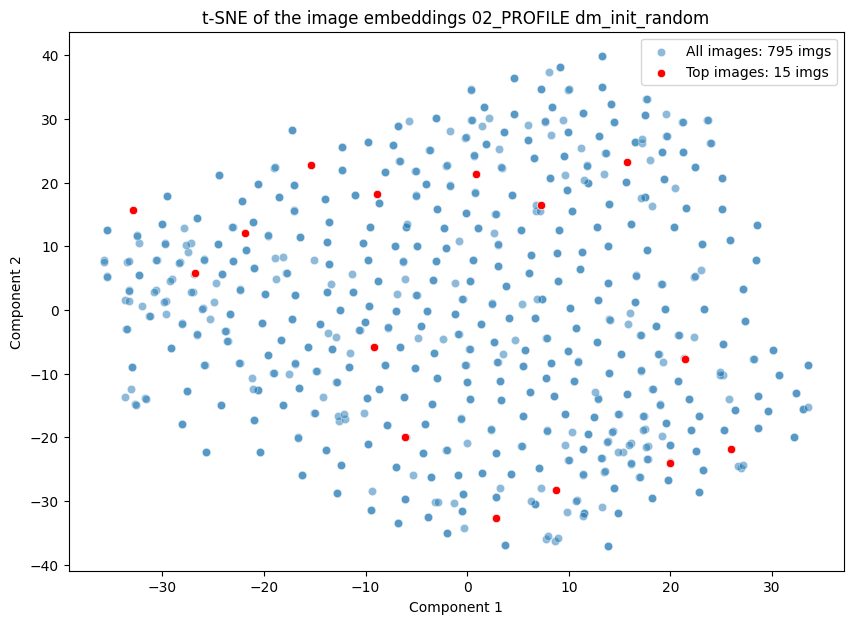

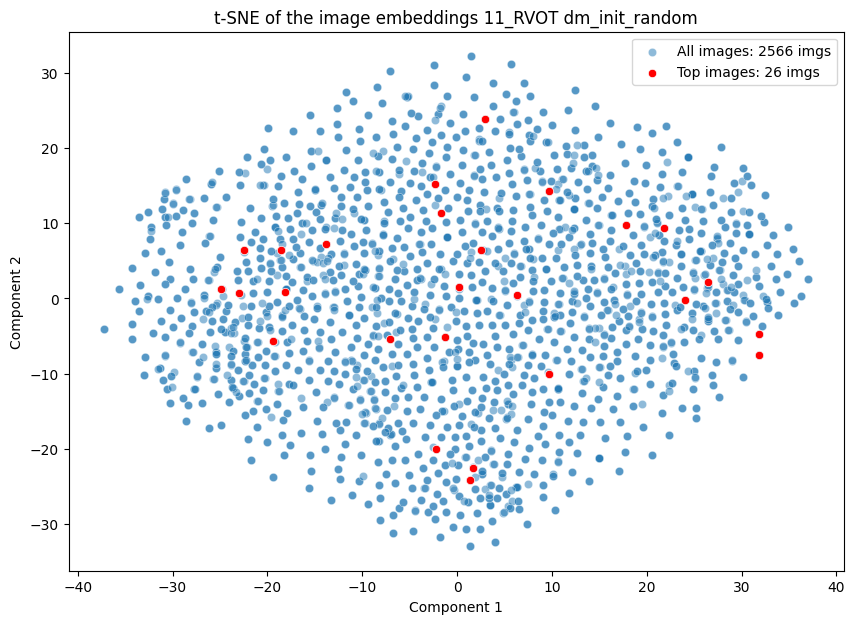

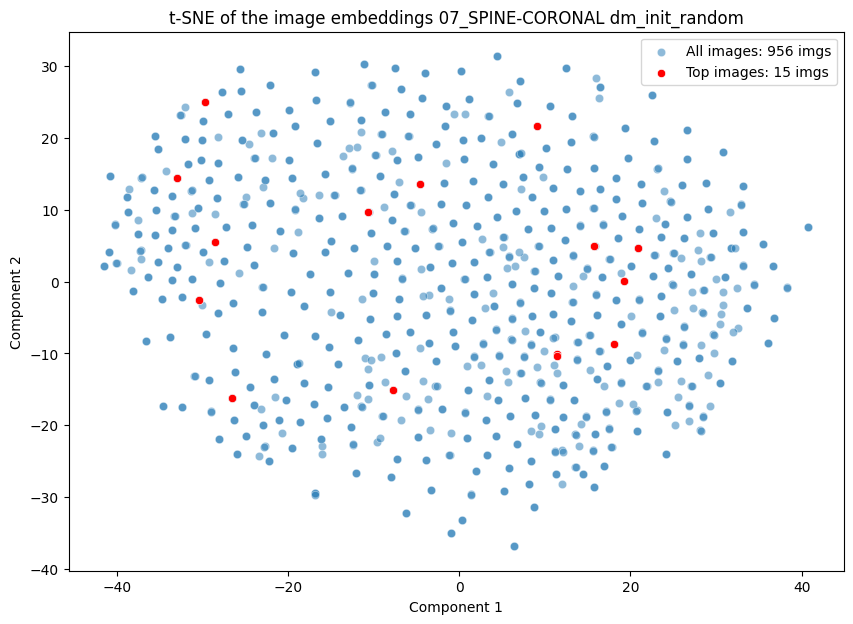

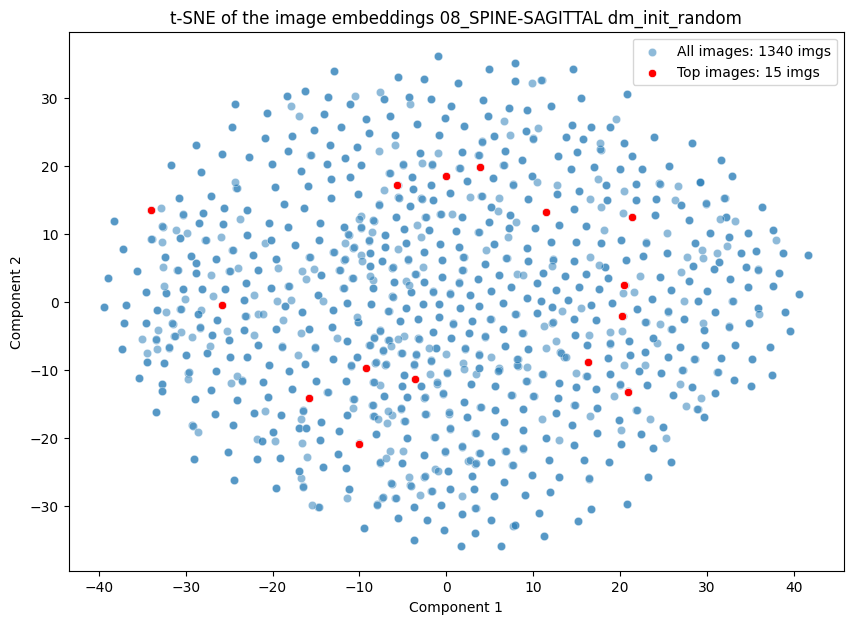

In [26]:
save_path = f"./experiment_res/embedding_plot/{args.method}"
if not os.path.exists(save_path):
    os.makedirs(save_path)
plot_embedding(img_latent_mean_all_list, mse_latent_dict, args, save_path)

In [27]:
mse_latent_dict_dir = f"./{args.method}_mse_latent_dict" if args.use_gan else f"./{args.method}_mse_latent_dict_no_gan"
if not os.path.exists(mse_latent_dict_dir):
    os.makedirs(mse_latent_dict_dir)

In [28]:
if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
else:
    save_name = f"{args.dataset}_{args.ipc:03d}.pkl"

mse_latent_dict_path = os.path.join(mse_latent_dict_dir, save_name)
with open(mse_latent_dict_path, 'wb') as file:
    pickle.dump(mse_latent_dict, file)

In [29]:
# Open the file in read-binary mode and load the dictionary
if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
else:
    save_name = f"{args.dataset}_{args.ipc:03d}.pkl"

mse_latent_dict_path = os.path.join(mse_latent_dict_dir, save_name)
with open(mse_latent_dict_path, 'rb') as file:
    mse_latent_dict = pickle.load(file)
    print(f"Load: {mse_latent_dict_path}")

Load: ./dm_init_random_mse_latent_dict_no_gan/ultrasound_0__01.pkl


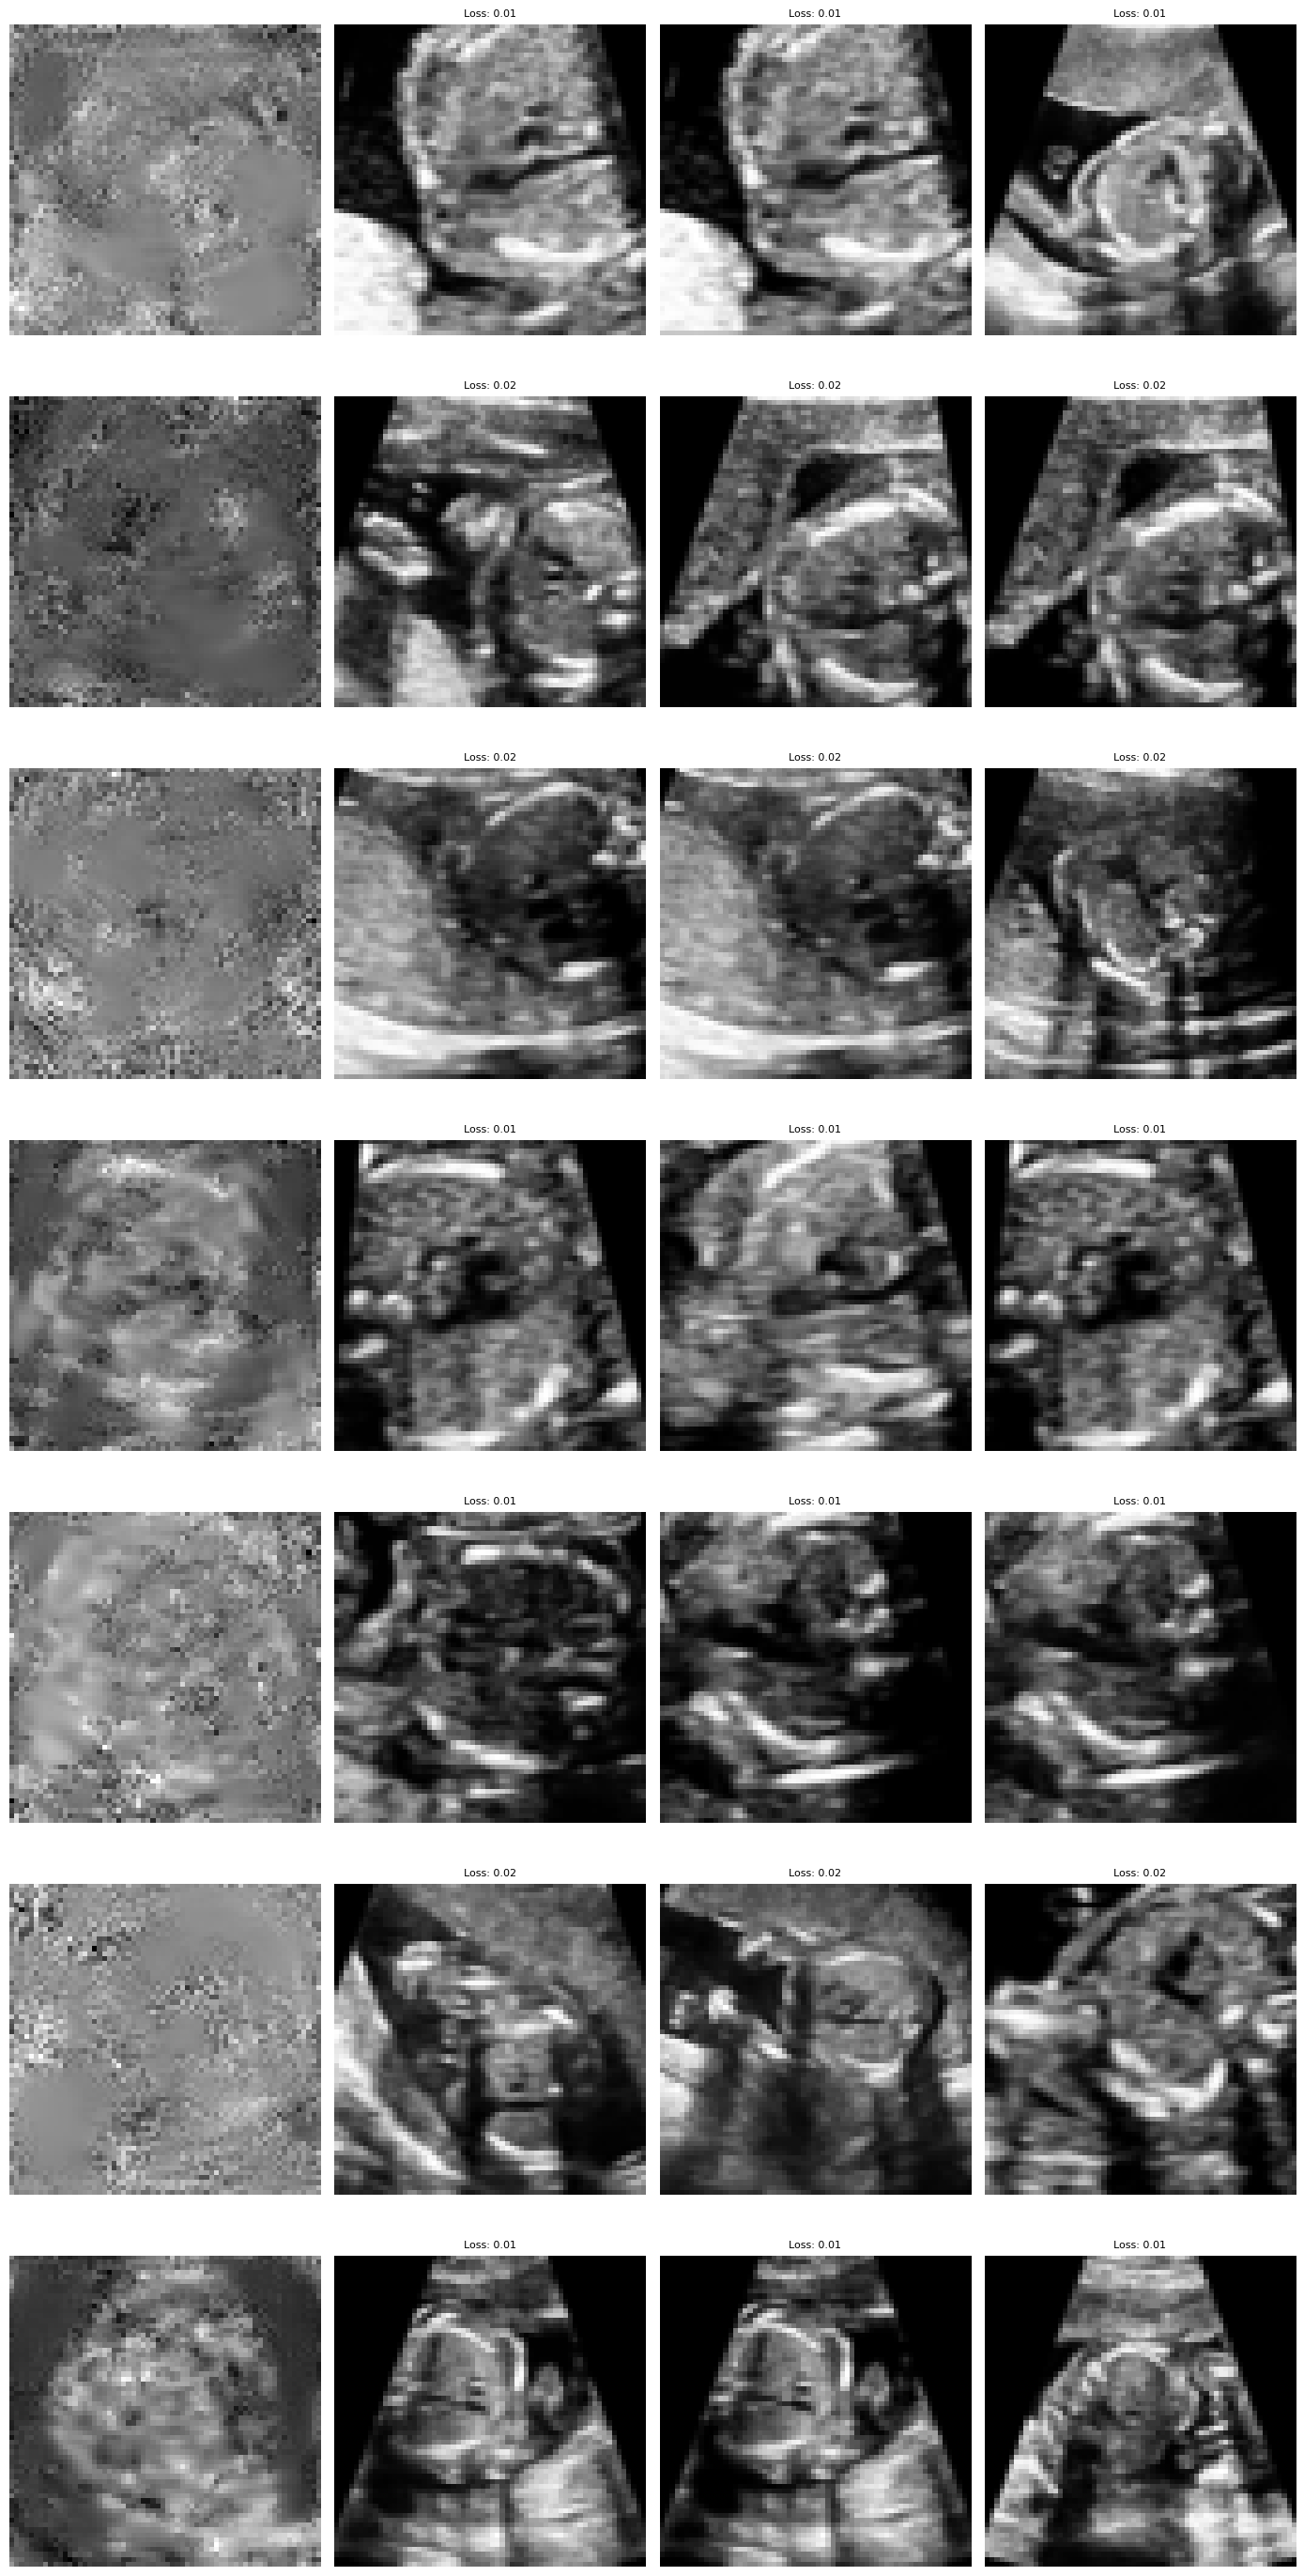

In [30]:
top_k = 3
num_img = 7

for c in range(num_classes):
    all_img_top_k_list = []
    similarity_loss_list = []
    for latent_idx in range(num_img):

        k = (c, latent_idx)
        mse_val_list = sorted(mse_latent_dict[k])[:top_k]
        top_img_idx = [e[1] for e in mse_val_list]
        similarity_loss = [e[0] for e in mse_val_list]
        top_imgs = images_all[top_img_idx].detach().cpu()
        if args.use_sample_ratio:
            latent = torch.unsqueeze(tensor_split[c][latent_idx], 0).detach().cpu()
        else:
            latent = torch.unsqueeze(latents_tmp[(c, latent_idx)], 0).detach().cpu()
        if len(latent.shape) == 3:
            latent = torch.unsqueeze(latent, 0)
        # print(latent.shape, top_imgs.shape)
        all_img_top_k = torch.cat((latent, top_imgs))
        all_img_top_k_list.append(all_img_top_k)
        similarity_loss_list.append(similarity_loss)
        

    plot_images_with_similarity(all_img_top_k_list, similarity_loss_list, num_img, num_classes=num_classes)
    break

# Train Top K Images

In [31]:
args.epoch_eval_train = 500

In [32]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

top_k = 1

print(f" ----- top k: {top_k} ----- ")
top_image_list = []
top_label_list = []

for (c, latent_idx) in tqdm(mse_latent_dict):
    k = (c, latent_idx)
    mse_val_list = sorted(mse_latent_dict[k])[:top_k]
    top_img_idx = [e[1] for e in mse_val_list]
    top_imgs = images_all[top_img_idx]
    top_image_list.append(top_imgs)
    top_label_list += [c]*top_k

top_image_list = torch.cat(top_image_list)
top_label_list = torch.tensor(top_label_list)

 ----- top k: 1 ----- 


100%|██████████| 618/618 [00:03<00:00, 199.74it/s]


In [35]:
res_subset_dict = {}

model_eval_list = ["ConvNet"]
# model_eval_list = ["ResNet18", "VGG11", "ViT"]
eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    args.lr_net = eval_pool_dict[model_eval]
    print(f"model: {model_eval}")
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) # get a random model
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(
            it_eval, net, top_image_list, top_label_list, testloader, args, decay="cosine", aug=True
        )
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    res_subset_dict[model_eval] = metric_test_all

model: ConvNet


  0%|          | 0/500 [00:00<?, ?it/s]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 1/500 [00:00<01:46,  4.69it/s]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 2/500 [00:00<01:29,  5.59it/s]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cud

In [36]:
dir = f"../experiment_res/subset_{args.method}" if args.use_gan else f"../experiment_res/subset_{args.method}_no_gan"

if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
    file_prefix = f'subset_{args.method}_{str(args.sample_ratio).replace(".", "__")}_' if args.use_gan else f'subset_{args.method}_no_gan_{str(args.sample_ratio).replace(".", "__")}_'
else:
    save_name = f'{args.dataset}_{str(args.ipc).replace(".", "__")}.pkl'
    file_prefix = f"subset_{args.method}_" if args.use_gan else f"subset_{args.method}_no_gan_"


save_res_dict_excel(res_subset_dict, test_class_count, dir, file_prefix=file_prefix)

Accuracy avg:0.694653, std:0.007243
Save at: ../experiment_res/subset_dm_init_random_no_gan/subset_dm_init_random_no_gan_0__01_ultrasound_050_ConvNet.xlsx
